In [1]:
# 📌 [기본 패키지 임포트]
import os
import shutil
import torch
import ultralytics
from ultralytics import YOLO
import time
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
from glob import glob
from collections import Counter
import threading

In [2]:
# 📌 [1] GPU 및 환경 체크
print("✅ CUDA 사용 가능:", torch.cuda.is_available())
print("✅ PyTorch 버전:", torch.__version__)
ultralytics.checks()

Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Setup complete  (24 CPUs, 31.7 GB RAM, 24.9/735.1 GB disk)


In [3]:
# 📌 [2] 실패한 이전 runs 삭제
def clean_incomplete_runs(base_dir='../code/runs/detect'):
    if not os.path.exists(base_dir):
        print(f"📂 '{base_dir}' 폴더가 없어 삭제 생략")
        return

    deleted = False
    for folder in os.listdir(base_dir):
        path = os.path.join(base_dir, folder)
        best_model = os.path.join(path, 'weights', 'best.pt')
        if not os.path.exists(best_model):
            print(f"🧹 삭제 대상: {path}")
            shutil.rmtree(path)
            deleted = True

    if not deleted:
        print("✅ 삭제할 미완성 run 없음. 모든 run이 best.pt 포함.")

clean_incomplete_runs()

✅ 삭제할 미완성 run 없음. 모든 run이 best.pt 포함.


In [4]:
# 📌 [3] 가장 최근 run 결과 요약 출력
def get_last_run_csv():
    runs = sorted(glob('runs/detect/*/results.csv'), key=os.path.getmtime, reverse=True)
    if runs:
        print(f"📄 마지막 훈련 결과 파일: {runs[0]}")
        df = pd.read_csv(runs[0])
        print("🔁 마지막 훈련 결과 (마지막 5줄):")
        print(df.tail())
    else:
        print("ℹ️ 이전 훈련 결과 없음.")

get_last_run_csv()

📄 마지막 훈련 결과 파일: runs/detect\yolov11n_custom_002\results.csv
🔁 마지막 훈련 결과 (마지막 5줄):
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
25     26  6314.87         0.54487         1.42637         0.94978   
26     27  6539.40         0.55126         1.42283         0.95562   
27     28  6768.79         0.53685         1.39680         0.94422   
28     29  6998.81         0.54541         1.39211         0.94520   
29     30  7228.67         0.54086         1.38914         0.94671   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
25               0.91847            0.79311           0.87818   
26               0.91802            0.80232           0.88047   
27               0.92164            0.80678           0.88419   
28               0.91056            0.80861           0.88437   
29               0.92094            0.81296           0.88409   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
25              0.76407    

In [5]:
# 📌 [4] 자동 넘버링 run 이름 생성
def get_next_run_name(base_dir='runs/detect', prefix='yolov11n_custom'):
    i = 1
    while os.path.exists(os.path.join(base_dir, f'{prefix}_{i:03d}')):
        i += 1
    return f'{prefix}_{i:03d}'

run_name = get_next_run_name()
print(f"🚀 새 훈련 run 이름: {run_name}")

🚀 새 훈련 run 이름: yolov11n_custom_003


In [6]:
# 📌 [5] 입력 데이터 정보 출력 및 클래스별 레이블 개수 확인 함수 추가
def get_dataset_info(img_dir, label_dir, class_names=None):
    img_files = glob(os.path.join(img_dir, '*.jpg'))
    label_files = glob(os.path.join(label_dir, '*.txt'))

    total_img_size = sum(os.path.getsize(f) for f in img_files)
    total_label_size = sum(os.path.getsize(f) for f in label_files)

    print(f"\n📁 이미지 경로: {img_dir}")
    print(f"🖼️ 이미지 개수: {len(img_files)}")
    print(f"💾 이미지 용량: {total_img_size / 1024 / 1024:.2f} MB")
    print(f"📄 라벨 경로: {label_dir}")
    print(f"📝 라벨 개수: {len(label_files)}")
    print(f"💾 라벨 용량: {total_label_size / 1024:.2f} KB")

    # 클래스별 라벨 개수 집계
    classes = []
    for f in label_files:
        with open(f, 'r') as file:
            lines = file.readlines()
            classes += [int(line.split()[0]) for line in lines if line.strip()]
    counter = Counter(classes)
    print(f"\n📊 클래스별 라벨 개수 ({label_dir}):")
    if class_names:
        for cls_idx, count in sorted(counter.items()):
            print(f"  {cls_idx} ({class_names[cls_idx]}): {count}")
    else:
        print(counter)

# 예시로 data.yaml에서 클래스명 읽어오기
import yaml
with open('data.yaml', 'r') as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg.get('names', None)

get_dataset_info('../train/images', '../train/labels', class_names)
get_dataset_info('../valid/images', '../valid/labels', class_names)


📁 이미지 경로: ../train/images
🖼️ 이미지 개수: 3530
💾 이미지 용량: 67.55 MB
📄 라벨 경로: ../train/labels
📝 라벨 개수: 3530
💾 라벨 용량: 319.50 KB

📊 클래스별 라벨 개수 (../train/labels):
  0 (Green Light): 542
  1 (Red Light): 585
  2 (Speed Limit 10): 19
  3 (Speed Limit 100): 267
  4 (Speed Limit 110): 101
  5 (Speed Limit 120): 252
  6 (Speed Limit 20): 285
  7 (Speed Limit 30): 334
  8 (Speed Limit 40): 235
  9 (Speed Limit 50): 283
  10 (Speed Limit 60): 301
  11 (Speed Limit 70): 318
  12 (Speed Limit 80): 323
  13 (Speed Limit 90): 168
  14 (Stop): 285

📁 이미지 경로: ../valid/images
🖼️ 이미지 개수: 801
💾 이미지 용량: 15.38 MB
📄 라벨 경로: ../valid/labels
📝 라벨 개수: 801
💾 라벨 용량: 69.86 KB

📊 클래스별 라벨 개수 (../valid/labels):
  0 (Green Light): 122
  1 (Red Light): 108
  3 (Speed Limit 100): 52
  4 (Speed Limit 110): 17
  5 (Speed Limit 120): 60
  6 (Speed Limit 20): 56
  7 (Speed Limit 30): 74
  8 (Speed Limit 40): 55
  9 (Speed Limit 50): 71
  10 (Speed Limit 60): 76
  11 (Speed Limit 70): 78
  12 (Speed Limit 80): 56
  13 (Speed Limit 

In [7]:
# 📌 캐시 파일 삭제 함수
# def safe_delete_cache(path: str):
#     if not os.path.exists(path):
#         print(f"🟢 캐시 파일 없음 (삭제 불필요): {path}")
#         return

#     file_size = os.path.getsize(path)
#     last_modified = os.path.getmtime(path)
#     now = time.time()

#     should_delete = (
#         file_size < 1024 or  # 1KB 이하
#         (now - last_modified > 3600)  # 1시간 이상 경과
#     )

#     if should_delete:
#         try:
#             os.remove(path)
#             print(f"✅ 캐시 삭제 완료: {path}")
#         except Exception as e:
#             print(f"❌ 캐시 삭제 실패: {path} → {e}")
#     else:
#         print(f"🔒 캐시 유지: {path} (조건 미충족)")

# safe_delete_cache(r"D:\Project\PJT_07\train\labels.cache")
# safe_delete_cache(r"D:\Project\PJT_07\valid\labels.cache")

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# GPU 메모리 사용량 주기적으로 출력 (간격 60초로 조정)
def gpu_monitor():
    while True:
        if torch.cuda.is_available():
            mem_alloc = torch.cuda.memory_allocated() / 1024**2
            mem_reserved = torch.cuda.memory_reserved() / 1024**2
            print(f"[GPU 모니터] 메모리 할당: {mem_alloc:.1f}MB, 예약: {mem_reserved:.1f}MB")
        time.sleep(60)  # 60초 간격

monitor_thread = threading.Thread(target=gpu_monitor, daemon=True)
monitor_thread.start()

# 모델 로드
model = YOLO('yolo11n.pt')
# model = YOLO('runs/detect/yolov11n_custom_001/weights/best.pt')  # 기존 모델에서 이어서 학습 시

# 하이퍼파라미터 튜닝 포함한 train 함수 호출
start_time = time.time()

model.train(
    data='data.yaml',
    epochs=30,
    imgsz=640,
    batch=8,
    name=run_name,
    device='0',
    workers=0,
    verbose=True  # 더 자세한 로그 출력
)

train_duration = time.time() - start_time
print(f"✅ 훈련 소요 시간: {train_duration:.2f}초")

[GPU 모니터] 메모리 할당: 0.0MB, 예약: 0.0MB
Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_custom_003, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

train: Scanning D:\Project\PJT_07\train\labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530


val: Fast image access  (ping: 0.10.0 ms, read: 57.639.7 MB/s, size: 20.7 KB)


val: Scanning D:\Project\PJT_07\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801


Plotting labels to runs\detect\yolov11n_custom_003\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov11n_custom_003
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.25G     0.9582      4.202      1.291         22        640:  31%|███       | 137/442 [00:42<01:07

[GPU 모니터] 메모리 할당: 142.3MB, 예약: 1278.0MB


       1/30      1.25G      0.863      3.558      1.191          9        640:  99%|█████████▉| 437/442 [01:42<00:01

[GPU 모니터] 메모리 할당: 1036.7MB, 예약: 1278.0MB


       1/30      1.25G      0.862      3.549      1.191          4        640: 100%|██████████| 442/442 [01:43<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.202      0.398      0.247      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.43G     0.7875      2.717      1.108         20        640:  55%|█████▍    | 243/442 [00:48<00:37

[GPU 모니터] 메모리 할당: 625.2MB, 예약: 1460.0MB


       2/30      1.44G     0.7975      2.622      1.114          2        640: 100%|██████████| 442/442 [01:28<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.331      0.462      0.376      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.44G      0.753      2.415      1.118         19        640:  11%|█         | 48/442 [00:09<01:18,

[GPU 모니터] 메모리 할당: 868.1MB, 예약: 1476.0MB


       3/30      1.44G     0.7958      2.283      1.112         18        640:  77%|███████▋  | 342/442 [01:09<00:19

[GPU 모니터] 메모리 할당: 220.5MB, 예약: 1476.0MB


       3/30      1.46G     0.7815      2.239      1.106          2        640: 100%|██████████| 442/442 [01:29<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.545      0.535      0.514      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.46G     0.7502      2.031      1.106         11        640:  33%|███▎      | 145/442 [00:29<00:57

[GPU 모니터] 메모리 할당: 235.7MB, 예약: 1492.0MB


       4/30      1.47G     0.7461      1.938      1.084          5        640: 100%|██████████| 442/442 [01:28<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|▉         | 5/51 [00:

[GPU 모니터] 메모리 할당: 244.3MB, 예약: 1506.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.601      0.562      0.585      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.47G     0.7315      1.698      1.078         17        640:  54%|█████▍    | 239/442 [00:50<00:42

[GPU 모니터] 메모리 할당: 1101.4MB, 예약: 1506.0MB


       5/30      1.47G     0.7282      1.698      1.071          5        640: 100%|██████████| 442/442 [01:33<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.647      0.579      0.668       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.47G     0.6607      1.572      1.051         11        640:   7%|▋         | 29/442 [00:06<01:30,

[GPU 모니터] 메모리 할당: 205.3MB, 예약: 1506.0MB


       6/30      1.47G     0.7024      1.526      1.053         16        640:  68%|██████▊   | 302/442 [01:06<00:30

[GPU 모니터] 메모리 할당: 167.3MB, 예약: 1506.0MB


       6/30      1.47G     0.7037      1.502      1.055          4        640: 100%|██████████| 442/442 [01:37<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944       0.73      0.709      0.784       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.47G     0.7046      1.401      1.057         21        640:  18%|█▊        | 79/442 [00:17<01:17,

[GPU 모니터] 메모리 할당: 177.0MB, 예약: 1506.0MB


       7/30      1.47G        0.7      1.373      1.054         23        640:  80%|████████  | 355/442 [01:17<00:19

[GPU 모니터] 메모리 할당: 167.3MB, 예약: 1506.0MB


       7/30      1.47G     0.6954      1.367      1.053          4        640: 100%|██████████| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.856      0.661      0.781      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.47G     0.6929       1.27      1.047         20        640:  31%|███       | 138/442 [00:30<01:06

[GPU 모니터] 메모리 할당: 182.5MB, 예약: 1506.0MB


       8/30      1.47G      0.678      1.265      1.046         24        640:  93%|█████████▎| 412/442 [01:30<00:06

[GPU 모니터] 메모리 할당: 1105.1MB, 예약: 1506.0MB


       8/30      1.47G     0.6773       1.27      1.045          2        640: 100%|██████████| 442/442 [01:37<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.823        0.7      0.811      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.47G     0.6852      1.203      1.049         22        640:  44%|████▍     | 195/442 [00:42<00:56

[GPU 모니터] 메모리 할당: 187.6MB, 예약: 1506.0MB


       9/30      1.47G     0.6788      1.186      1.043          4        640: 100%|██████████| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 28/51 [00

[GPU 모니터] 메모리 할당: 244.3MB, 예약: 1506.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.896      0.764      0.852      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.47G     0.6461      1.123      1.031         14        640:  56%|█████▌    | 247/442 [00:54<00:42

[GPU 모니터] 메모리 할당: 908.9MB, 예약: 1506.0MB


      10/30      1.47G     0.6497      1.105      1.027          7        640: 100%|██████████| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.872      0.746      0.845      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.47G     0.6869      1.112      1.064         15        640:   7%|▋         | 29/442 [00:06<01:29,

[GPU 모니터] 메모리 할당: 250.8MB, 예약: 1506.0MB


      11/30      1.47G     0.6494       1.08      1.028         14        640:  68%|██████▊   | 300/442 [01:06<00:32

[GPU 모니터] 메모리 할당: 212.8MB, 예약: 1506.0MB


      11/30      1.49G     0.6501      1.065      1.026          2        640: 100%|██████████| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.875      0.775      0.864      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.49G     0.6462      1.066      1.009         20        640:  20%|██        | 89/442 [00:19<01:16,

[GPU 모니터] 메모리 할당: 1034.2MB, 예약: 1522.0MB


      12/30      1.49G     0.6294      1.031       1.01         24        640:  82%|████████▏ | 364/442 [01:19<00:17

[GPU 모니터] 메모리 할당: 152.1MB, 예약: 1522.0MB


      12/30      1.49G     0.6363      1.022      1.016          9        640: 100%|██████████| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.885      0.794      0.877      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.49G       0.62     0.9711      1.014         24        640:  32%|███▏      | 143/442 [00:31<01:04

[GPU 모니터] 메모리 할당: 205.3MB, 예약: 1522.0MB


      13/30      1.49G     0.6326     0.9715       1.02         17        640:  93%|█████████▎| 411/442 [01:31<00:07

[GPU 모니터] 메모리 할당: 157.3MB, 예약: 1522.0MB


      13/30      1.49G     0.6301     0.9739       1.02          3        640: 100%|██████████| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.929      0.771      0.888      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.49G     0.6216     0.9532      1.018         10        640:  45%|████▍     | 198/442 [00:42<00:52

[GPU 모니터] 메모리 할당: 205.3MB, 예약: 1522.0MB


      14/30      1.49G     0.6233      0.942      1.014          2        640: 100%|██████████| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▍   | 33/51 [00

[GPU 모니터] 메모리 할당: 266.3MB, 예약: 1522.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.904      0.805      0.894       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.49G     0.5958     0.8744      1.006         21        640:  59%|█████▉    | 261/442 [00:56<00:38

[GPU 모니터] 메모리 할당: 182.5MB, 예약: 1522.0MB


      15/30      1.49G     0.6023     0.8813      1.008          6        640: 100%|██████████| 442/442 [01:35<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944       0.92       0.83      0.906      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.49G     0.6062     0.8497      1.013         19        640:  10%|█         | 45/442 [00:10<01:31,

[GPU 모니터] 메모리 할당: 762.8MB, 예약: 1522.0MB


      16/30      1.49G     0.6103     0.8553     0.9988         14        640:  71%|███████   | 314/442 [01:10<00:27

[GPU 모니터] 메모리 할당: 235.7MB, 예약: 1522.0MB


      16/30      1.49G     0.6056     0.8527     0.9991          6        640: 100%|██████████| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.932      0.822        0.9      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.49G     0.6085     0.8469     0.9953         25        640:  21%|██▏       | 94/442 [00:20<01:19,

[GPU 모니터] 메모리 할당: 235.7MB, 예약: 1522.0MB


      17/30      1.49G     0.6053     0.8442     0.9956         18        640:  83%|████████▎ | 366/442 [01:21<00:16

[GPU 모니터] 메모리 할당: 235.7MB, 예약: 1522.0MB


      17/30      1.49G     0.6072     0.8532     0.9961          3        640: 100%|██████████| 442/442 [01:37<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.949      0.826      0.909      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.49G     0.6065     0.8179      1.018         20        640:  33%|███▎      | 146/442 [00:32<01:05

[GPU 모니터] 메모리 할당: 235.7MB, 예약: 1522.0MB


      18/30      1.49G      0.599     0.8114      1.004         21        640:  96%|█████████▋| 426/442 [01:32<00:03

[GPU 모니터] 메모리 할당: 893.5MB, 예약: 1522.0MB


      18/30      1.49G     0.5985     0.8064      1.003          5        640: 100%|██████████| 442/442 [01:35<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.918      0.854      0.913      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.49G     0.5916     0.7899     0.9903         10        640:  47%|████▋     | 209/442 [00:46<00:52

[GPU 모니터] 메모리 할당: 205.3MB, 예약: 1522.0MB


      19/30      1.49G     0.5971     0.7895     0.9933          4        640: 100%|██████████| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 40/51 [00

[GPU 모니터] 메모리 할당: 264.1MB, 예약: 1522.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.959      0.837      0.917      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.49G     0.5749     0.7573     0.9807         16        640:  62%|██████▏   | 274/442 [00:57<00:35

[GPU 모니터] 메모리 할당: 985.3MB, 예약: 1522.0MB


      20/30      1.49G     0.5819     0.7715     0.9862          5        640: 100%|██████████| 442/442 [01:28<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944       0.94      0.847      0.924      0.788


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.49G     0.5794     0.5454     0.9563         10        640:  25%|██▌       | 112/442 [00:20<01:00

[GPU 모니터] 메모리 할당: 197.7MB, 예약: 1522.0MB


      21/30      1.49G     0.5697     0.5473     0.9558          2        640: 100%|██████████| 442/442 [01:14<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▍   | 33/51 [00

[GPU 모니터] 메모리 할당: 244.3MB, 예약: 1522.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.953      0.842      0.922      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.49G     0.5626     0.5273     0.9498         10        640:  76%|███████▌  | 336/442 [00:56<00:18

[GPU 모니터] 메모리 할당: 197.7MB, 예약: 1522.0MB


      22/30      1.49G     0.5583     0.5265     0.9456          2        640: 100%|██████████| 442/442 [01:15<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.956      0.842      0.922      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.49G     0.5651     0.5088     0.9507         11        640:  41%|████      | 181/442 [00:31<00:44

[GPU 모니터] 메모리 할당: 1120.1MB, 예약: 1522.0MB


      23/30      1.49G     0.5544     0.5025     0.9496          6        640: 100%|██████████| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.917      0.861      0.928      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.49G        0.6     0.5392     0.9994          8        640:   4%|▍         | 18/442 [00:03<01:17,

[GPU 모니터] 메모리 할당: 460.9MB, 예약: 1522.0MB


      24/30      1.49G      0.542     0.4761     0.9437          9        640:  81%|████████▏ | 360/442 [01:03<00:14

[GPU 모니터] 메모리 할당: 849.5MB, 예약: 1522.0MB


      24/30       1.5G     0.5475     0.4814     0.9432          2        640: 100%|██████████| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.963      0.847      0.931      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       1.5G     0.5328     0.4607     0.9356          9        640:  47%|████▋     | 207/442 [00:36<00:41

[GPU 모니터] 메모리 할당: 266.0MB, 예약: 1536.0MB


      25/30       1.5G     0.5413     0.4665      0.941          3        640: 100%|██████████| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.954      0.848      0.933      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       1.5G     0.5429     0.4473     0.9347         15        640:  12%|█▏        | 55/442 [00:09<01:06,

[GPU 모니터] 메모리 할당: 592.0MB, 예약: 1536.0MB


      26/30       1.5G     0.5281     0.4471     0.9339         11        640:  90%|█████████ | 400/442 [01:09<00:07

[GPU 모니터] 메모리 할당: 167.3MB, 예약: 1536.0MB


      26/30       1.5G      0.525     0.4421     0.9318          2        640: 100%|██████████| 442/442 [01:16<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.945      0.859      0.938      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       1.5G     0.5143     0.4252     0.9296         10        640:  29%|██▉       | 129/442 [00:23<00:56

[GPU 모니터] 메모리 할당: 167.3MB, 예약: 1536.0MB


      27/30       1.5G     0.5254      0.441     0.9332          5        640: 100%|██████████| 442/442 [10:50<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▍   | 33/51 [00

[GPU 모니터] 메모리 할당: 213.9MB, 예약: 1536.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.948       0.86      0.939      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       1.5G     0.5151     0.4335     0.9207          8        640:  73%|███████▎  | 321/442 [00:56<00:23

[GPU 모니터] 메모리 할당: 220.5MB, 예약: 1536.0MB


      28/30       1.5G     0.5153     0.4327     0.9235          2        640: 100%|██████████| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.967      0.848      0.943      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       1.5G     0.5326     0.4276     0.9254         10        640:  39%|███▉      | 172/442 [00:30<00:49

[GPU 모니터] 메모리 할당: 405.0MB, 예약: 1536.0MB


      29/30       1.5G     0.5154      0.416     0.9218          2        640: 100%|██████████| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.943      0.877      0.945      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       1.5G     0.5064     0.3869     0.9251         10        640:   4%|▍         | 18/442 [00:03<01:16,

[GPU 모니터] 메모리 할당: 187.6MB, 예약: 1536.0MB


      30/30       1.5G     0.5061      0.411     0.9192         11        640:  83%|████████▎ | 365/442 [01:03<00:13

[GPU 모니터] 메모리 할당: 235.7MB, 예약: 1536.0MB


      30/30       1.5G     0.5054     0.4122     0.9193          2        640: 100%|██████████| 442/442 [01:16<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00

                   all        801        944      0.955      0.873      0.946      0.816



30 epochs completed in 0.988 hours.
Optimizer stripped from runs\detect\yolov11n_custom_003\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\yolov11n_custom_003\weights\best.pt, 5.5MB

Validating runs\detect\yolov11n_custom_003\weights\best.pt...
Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00


                   all        801        944      0.955      0.873      0.946      0.816
           Green Light         87        122      0.826      0.739      0.826      0.473
             Red Light         74        108      0.901      0.713      0.831      0.506
       Speed Limit 100         52         52      0.924      0.923      0.973       0.87
       Speed Limit 110         17         17          1      0.882      0.962       0.89
       Speed Limit 120         60         60      0.982        0.9      0.976      0.891
        Speed Limit 20         56         56      0.982      0.893      0.979      0.859
        Speed Limit 30         71         74      0.951      0.959      0.982      0.914
        Speed Limit 40         53         55      0.981      0.926      0.983      0.867
        Speed Limit 50         68         71      0.924      0.853      0.953      0.844
        Speed Limit 60         76         76      0.969      0.908      0.948      0.869
        Speed Limit 7

In [9]:
# 📌 [7] 검증 수행
# start_val = time.time()

# model = YOLO(f'runs/detect/{run_name}/weights/best.pt')
# results = model.val()
# val_duration = time.time() - start_val
# print(f"✅ 검증 소요 시간: {val_duration:.2f}초")
# print(f"mAP50: {results.box.map50:.4f}, mAP50-95: {results.box.map:.4f}")

# # PR Curve 시각화 (val 결과 내 PR curve 있으면)
# if hasattr(results, 'plots') and 'pr_curve' in results.plots:
#     plt.figure(figsize=(8,6))
#     plt.imshow(results.plots['pr_curve'])
#     plt.axis('off')
#     plt.title("PR Curve")
#     plt.show()

In [14]:
run_name = 'yolov11n_custom_003'

In [15]:
from ultralytics import YOLO
model = YOLO(f'runs/detect/{run_name}/weights/best.pt')

In [16]:
# 📌 [8] 예측 실행 및 저장
test_img = '../test/images/00014_00004_00020_png.rf.e3b35f3ca153fde99af4db4a67d2a564.jpg'
pred = model.predict(
    source=test_img,
    conf=0.25,
    save=True,
    project='runs/predict/custom_test',
    name=run_name,
    exist_ok=True
)


image 1/1 D:\Project\PJT_07\code\..\test\images\00014_00004_00020_png.rf.e3b35f3ca153fde99af4db4a67d2a564.jpg: 640x640 1 Stop, 22.0ms
Speed: 5.6ms preprocess, 22.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\predict\custom_test\yolov11n_custom_003


In [17]:
import yaml
with open('data.yaml', 'r') as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg.get('names', None)

import cv2
import matplotlib.pyplot as plt

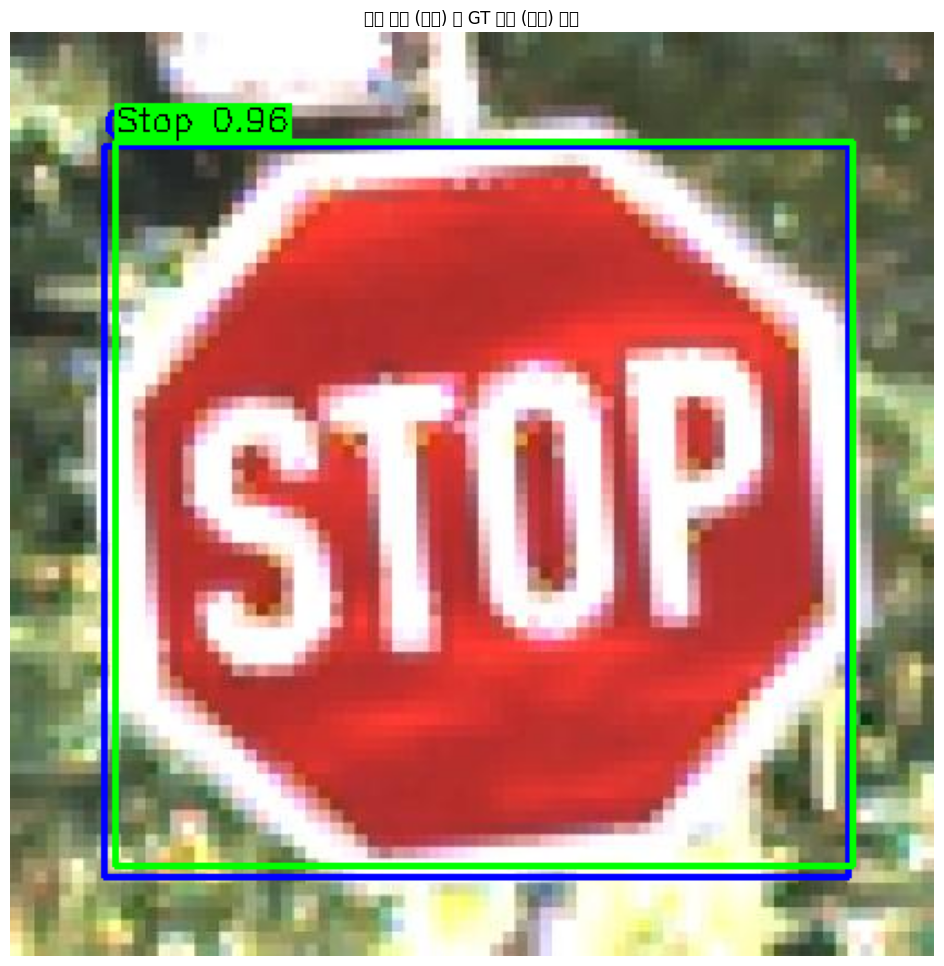

In [18]:
# 📌 [9] 예측 결과 시각화 및 GT bbox와 비교 함수 추가
def draw_boxes_with_gt(image_path, pred_results, gt_label_path, class_names):
    img = cv2.imread(image_path)
    ih, iw = img.shape[:2]

    # GT 박스 (파란색)
    with open(gt_label_path, 'r') as f:
        gt_lines = f.readlines()

    for line in gt_lines:
        cls, x, y, w, h = map(float, line.strip().split())
        x1 = int((x - w/2) * iw)
        y1 = int((y - h/2) * ih)
        x2 = int((x + w/2) * iw)
        y2 = int((y + h/2) * ih)
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(img, f"GT: {class_names[int(cls)]}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # 예측 박스 (초록색)
    for r in pred_results:
        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy().astype(int)
        for (x1,y1,x2,y2), conf, cls in zip(boxes, scores, classes):
            label = f"{class_names[cls]} {conf:.2f}"
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(img, (x1, y1 - th - 5), (x1 + tw, y1), (0,255,0), -1)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("예측 박스 (초록) 와 GT 박스 (파랑) 비교")
    plt.show()

gt_label_for_test_img = '../test/labels/00014_00004_00020_png.rf.e3b35f3ca153fde99af4db4a67d2a564.txt'
draw_boxes_with_gt(test_img, pred, gt_label_for_test_img, class_names)

In [40]:
# 📌 [10] ONNX 모델로 내보내기
export_path = model.export(format='onnx')
print(f"🧠 ONNX 모델 저장 경로: {export_path}")

Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CPU (13th Gen Intel Core(TM) i7-13700HX)

PyTorch: starting from 'runs\detect\yolov11n_custom_002\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success  2.7s, saved as 'runs\detect\yolov11n_custom_002\weights\best.onnx' (10.1 MB)

Export complete (3.3s)
Results saved to D:\Project\PJT_07\code\runs\detect\yolov11n_custom_002\weights
Predict:         yolo predict task=detect model=runs\detect\yolov11n_custom_002\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\yolov11n_custom_002\weights\best.onnx imgsz=640 data=data.yaml  
Visualize:       https://netron.app
🧠 ONNX 모델 저장 경로: runs\detect\yolov11n_custom_002\weights\best.onnx


In [20]:
import os

Loading runs\detect\yolov11n_custom_003\weights\best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Stop, 37.7ms
Speed: 5.0ms preprocess, 37.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


D:\Project\PJT_07\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Project\PJT_07\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Project\PJT_07\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


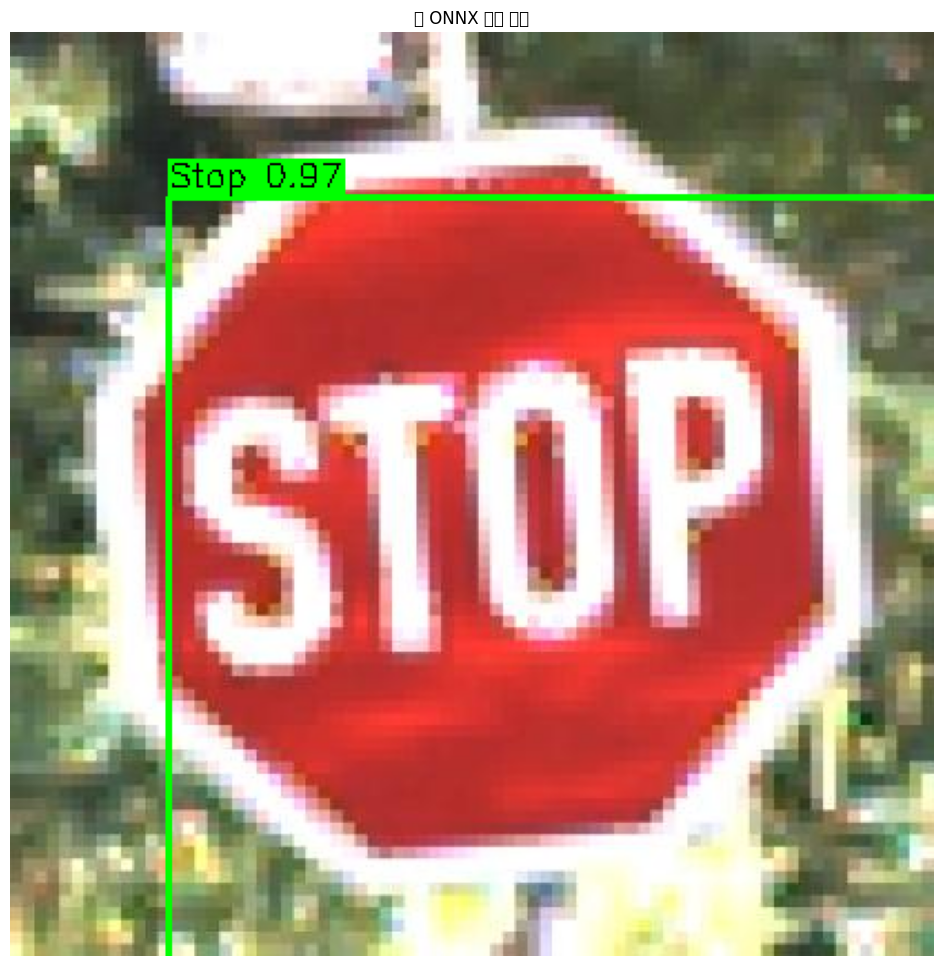

In [21]:
# 📌 [11] ONNX 모델 기반 예측 시각화 (기존 코드 유지)
onnx_model = YOLO(os.path.join('runs/detect', run_name, 'weights', 'best.onnx'))

image = cv2.imread(test_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (640, 640))

results_onnx = onnx_model(resized_image, imgsz=640)

for result in results_onnx:
    boxes = result.boxes
    names = result.names
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf[0]
        cls = int(box.cls[0])
        label = f"{names[cls]} {conf:.2f}"

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(image, (x1, y1 - text_height - 5), (x1 + text_width, y1), (0, 255, 0), -1)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.title("🔍 ONNX 예측 결과")
plt.show()

In [42]:
# print(df.columns)

In [24]:
import pandas as pd

print(run_name)

yolov11n_custom_003


📈 훈련 결과 요약 (Epoch별 mAP):
    metrics/mAP50(B)  metrics/mAP50-95(B)
25           0.93757              0.80491
26           0.93899              0.80909
27           0.94335              0.81435
28           0.94540              0.81500
29           0.94552              0.81616


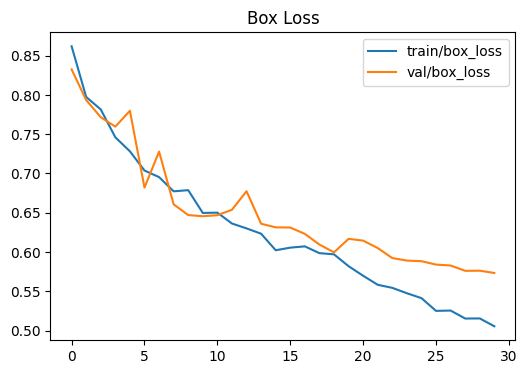

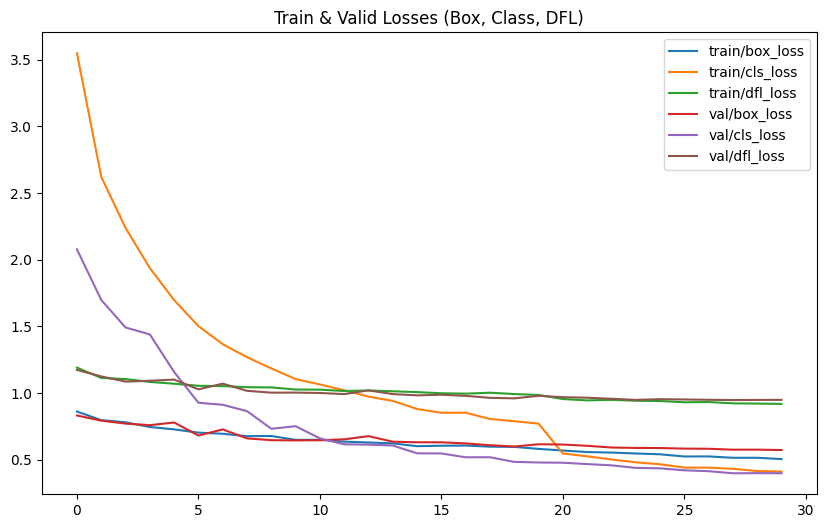

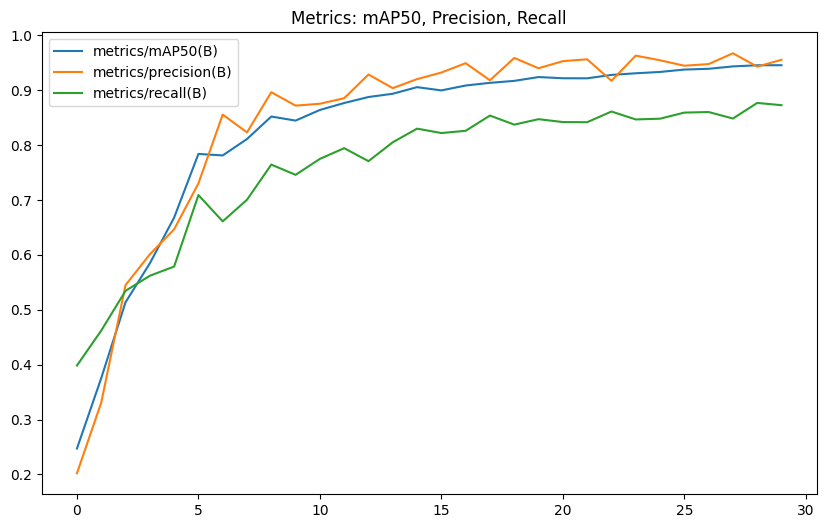

🎯 최고 성능 Epoch:
epoch                  30.00000
metrics/mAP50(B)        0.94552
metrics/mAP50-95(B)     0.81616
Name: 29, dtype: float64


In [25]:
# 📌 [12] 훈련 결과 시각화 (mAP/Loss 등)
results_csv = f'runs/detect/{run_name}/results.csv'

if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    print(f"📈 훈련 결과 요약 (Epoch별 mAP):\n{df[['metrics/mAP50(B)', 'metrics/mAP50-95(B)']].tail()}")

    # Box Loss 그래프
    df[['train/box_loss', 'val/box_loss']].plot(title='Box Loss', figsize=(6, 4))
    plt.savefig(f'runs/detect/{run_name}/box_loss.png')
    plt.show()

    # ✅ 수정: train/valid 전체 손실 시각화 (box, cls, dfl)
    df[['train/box_loss', 'train/cls_loss', 'train/dfl_loss',
        'val/box_loss', 'val/cls_loss', 'val/dfl_loss']].plot(figsize=(10,6))
    plt.title('Train & Valid Losses (Box, Class, DFL)')
    plt.savefig(f'runs/detect/{run_name}/losses.png')
    plt.show()

    # mAP, Precision, Recall 시각화
    df[['metrics/mAP50(B)', 'metrics/precision(B)', 'metrics/recall(B)']].plot(figsize=(10,6))
    plt.title('Metrics: mAP50, Precision, Recall')
    plt.savefig(f'runs/detect/{run_name}/metrics.png')
    plt.show()

    best_idx = df['metrics/mAP50-95(B)'].idxmax()
    print("🎯 최고 성능 Epoch:")
    print(df.loc[best_idx, ['epoch', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']])
else:
    print("📛 results.csv 없음 (훈련 실패?)")

In [27]:
import json

In [28]:
# 📌 [13] 결과를 JSON으로 저장
def save_results_to_json(csv_path, json_path):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        result_data = df.to_dict(orient='records')
        with open(json_path, 'w') as f:
            json.dump(result_data, f, indent=4)
        print(f"📦 결과 JSON 저장 완료: {json_path}")

save_results_to_json(
    csv_path=f'runs/detect/{run_name}/results.csv',
    json_path=f'runs/detect/{run_name}/results_summary.json'
)

📦 결과 JSON 저장 완료: runs/detect/yolov11n_custom_003/results_summary.json
